## Langkah 1: Pre-processing Dataset.

In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# --- Konfigurasi ---
DATASET_PATH = r"C:\Users\KuePuki\Documents\MKA\CVL\UADFV"
SEQUENCE_LENGTH = 30
IMG_SIZE = 96

# --- Inisialisasi Detektor Wajah ---
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# --- LANGKAH 1: Kumpulkan semua path video dan labelnya ---
all_video_paths = []
all_labels = []
categories = ['real', 'fake']

print("--- Step 1: Gathering all video file paths ---")
for category in categories:
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.isdir(category_path):
        print(f"Warning: Directory not found for category '{category}'. Skipping.")
        continue
    
    video_files = [f for f in os.listdir(category_path) if f.lower().endswith('.mp4')]
    for video_file in video_files:
        all_video_paths.append(os.path.join(category_path, video_file))
        all_labels.append(category)

print(f"Total videos found: {len(all_video_paths)}")

# --- LANGKAH 2: Bagi daftar path video menjadi 70% Training dan 30% Testing ---
print("\n--- Step 2: Splitting file paths into 70% training and 30% test ---")

# PERUBAHAN DI SINI: Hanya satu kali split dengan test_size=0.3
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_video_paths, all_labels,
    test_size=0.3,  # 30% untuk Test (Ujian Akhir), 70% untuk Train (akan di-K-Fold nanti)
    random_state=42,
    stratify=all_labels
)

print(f"Training videos (for Cross-Validation): {len(train_paths)}")
print(f"Test videos (for Final Eval): {len(test_paths)}")


# --- LANGKAH 3: Buat fungsi untuk memproses daftar video ---
def process_videos(video_paths, video_labels):
    """Fungsi ini mengambil daftar path video dan mengekstrak sekuens frame wajah."""
    sequences = []
    processed_labels = []
    
    for i, video_path in enumerate(video_paths):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Warning: Could not open video file {video_path}")
            continue

        frames = []
        while len(frames) < SEQUENCE_LENGTH:
            ret, frame = cap.read()
            if not ret:
                break
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            
            if len(faces) > 0:
                # Ambil wajah terbesar
                (x, y, w, h) = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
                face = frame[y:y+h, x:x+w]
                resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                frames.append(resized_face)
        
        cap.release()
        
        if len(frames) == SEQUENCE_LENGTH:
            sequences.append(frames)
            processed_labels.append(video_labels[i])
            print(f"  -> Processed '{os.path.basename(video_path)}'. Sequence ADDED.")
        else:
            print(f"  -> Skipped '{os.path.basename(video_path)}'. Not enough frames with faces found.")
            
    return np.array(sequences), np.array(processed_labels)

# --- LANGKAH 4: Proses setiap set data ---
# PERUBAHAN DI SINI: Hanya memproses Train dan Test. Validation dihapus.
print("\n--- Step 3: Processing TRAINING data ---")
X_train, y_train_str = process_videos(train_paths, train_labels)

print("\n--- Step 4: Processing TEST data ---")
X_test, y_test_str = process_videos(test_paths, test_labels)

# --- LANGKAH 5: Lakukan encoding pada label ---
print("\n--- Step 5: Encoding labels ---")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_str)
y_test = label_encoder.transform(y_test_str)

print(f"Label encoding: {list(label_encoder.classes_)} -> {label_encoder.transform(label_encoder.classes_)}")

print("\nPreprocessing complete!")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# --- LANGKAH 6: Simpan Hasil Preprocessing ---
OUTPUT_PATH = "processed_data"
os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"\nDirectory '{OUTPUT_PATH}' is ready.")

# PERUBAHAN DI SINI: Tidak menyimpan X_val/y_val
np.save(os.path.join(OUTPUT_PATH, 'X_train.npy'), X_train)
np.save(os.path.join(OUTPUT_PATH, 'y_train.npy'), y_train)
np.save(os.path.join(OUTPUT_PATH, 'X_test.npy'), X_test)
np.save(os.path.join(OUTPUT_PATH, 'y_test.npy'), y_test)
np.save(os.path.join(OUTPUT_PATH, 'label_encoder.npy'), label_encoder.classes_)

print("All processed data has been saved successfully! ✅")

--- Step 1: Gathering all video file paths ---
Total videos found: 98

--- Step 2: Splitting file paths into 70% training and 30% test ---
Training videos (for Cross-Validation): 68
Test videos (for Final Eval): 30

--- Step 3: Processing TRAINING data ---
  -> Processed '0020.mp4'. Sequence ADDED.
  -> Processed '0011_fake.mp4'. Sequence ADDED.
  -> Processed '0038.mp4'. Sequence ADDED.
  -> Processed '0029_fake.mp4'. Sequence ADDED.
  -> Processed '0021.mp4'. Sequence ADDED.
  -> Processed '0031.mp4'. Sequence ADDED.
  -> Processed '0045_fake.mp4'. Sequence ADDED.
  -> Processed '0032.mp4'. Sequence ADDED.
  -> Processed '0027_fake.mp4'. Sequence ADDED.
  -> Processed '0040.mp4'. Sequence ADDED.
  -> Processed '0006_fake.mp4'. Sequence ADDED.
  -> Processed '0041_fake.mp4'. Sequence ADDED.
  -> Processed '0009_fake.mp4'. Sequence ADDED.
  -> Processed '0030.mp4'. Sequence ADDED.
  -> Processed '0012_fake.mp4'. Sequence ADDED.
  -> Processed '0015.mp4'. Sequence ADDED.
  -> Processed 

## Langkah 2: Model Training 

In [1]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, TimeDistributed, 
                                     LSTM, Input, Bidirectional, BatchNormalization, 
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import regularizers

# --- KONFIGURASI ---
BATCH_SIZE = 16 
EPOCHS = 30      
N_SPLITS = 5     
IMG_SIZE = 96
DATA_PATH = "processed_data" # Sesuaikan folder

# --- 1. LOAD DATA ---
print("--- Loading Data ---")
X = np.load(os.path.join(DATA_PATH, 'X_train.npy')) 
y = np.load(os.path.join(DATA_PATH, 'y_train.npy'))

# [KRUSIAL 1] JANGAN BAGI DENGAN 255.0
# EfficientNetV2 mengharapkan range 0-255. Biarkan float32 saja.
X = X.astype('float32') 

print(f"Data Loaded. Shape: {X.shape}")
print(f"Range pixel contoh: min={X.min()}, max={X.max()} (Harusnya 0 s/d 255)")

# --- 2. FUNGSI MODEL (OPTIMIZED NO-FINETUNE) ---
def create_model(input_shape):
    # Base Model
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False # Tetap Frozen sesuai permintaan

    # Augmentation (Sedikit dikurangi agar tidak terlalu sulit belajarnya)
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.1),
    ], name='data_augmentation')

    model = Sequential([
        Input(shape=input_shape),
        TimeDistributed(data_augmentation),
        TimeDistributed(base_model),
        
        # [KRUSIAL 2] Gunakan Pooling, BUKAN Flatten
        # Flatten menghasilkan (Batch, Time, 3*3*1280) -> Terlalu besar & berisik
        # Pooling menghasilkan (Batch, Time, 1280) -> Padat & Jelas
        TimeDistributed(GlobalAveragePooling2D()),
        
        # [KRUSIAL 3] Sederhanakan LSTM
        # 1 Layer Bidirectional sudah cukup kuat untuk fitur beku
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=False)),
        
        BatchNormalization(),
        
        # Classifier Head
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5), # Dropout standar
        Dense(1, activation='sigmoid')
    ])

    # [KRUSIAL 4] Learning Rate lebih agresif
    # Karena base frozen, kita butuh LR lebih besar di awal untuk menggerakkan bobot LSTM
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# --- 3. EKSEKUSI TRAINING (SAMA SEPERTI SEBELUMNYA) ---
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []

print(f"\nStarting Optimized Training...")

for train_index, val_index in skf.split(X, y):
    print(f"\n=== FOLD {fold_no} ===")
    
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weight_dict = dict(enumerate(class_weights))

    model = create_model(input_shape=X_train_fold.shape[1:])
    
    callbacks = [
        # Early Stopping sedikit lebih sabar
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f'best_model_fold_{fold_no}.keras', monitor='val_loss', save_best_only=True, verbose=0)
    ]

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Score Fold {fold_no}: Accuracy={scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1] * 100)
    
    tf.keras.backend.clear_session()
    fold_no += 1

print(f"\nRata-rata Akurasi: {np.mean(acc_per_fold):.2f}%")

--- Loading Data ---
Data Loaded. Shape: (68, 30, 96, 96, 3)
Range pixel contoh: min=0.0, max=255.0 (Harusnya 0 s/d 255)

Starting Optimized Training...

=== FOLD 1 ===
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 246s 21s/step - accuracy: 0.4630 - loss: 1.1939 - val_accuracy: 0.6429 - val_loss: 0.7764 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.4630 - loss: 0.9294 - val_accuracy: 0.7143 - val_loss: 0.7528 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.7222 - loss: 0.6765 - val_accuracy: 0.7143 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7593 - loss: 0.6088 - val_accuracy: 0.7143 - val_loss: 0.7150 - learning_rate: 0.0010
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6852 - loss: 0.6078 - val_accuracy: 0.7143 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7963 - loss: 0.4744 - val_a

## Langkah 3: Testing

--- 1. Memuat Data Testing (30% Hold-out) ---
Error: File .npy tidak ditemukan. Jalankan preprocessing terlebih dahulu.
--- Regenerasi Path Video untuk Labeling... ---
Sinkronisasi Path Video Berhasil.

--- 2. Memuat Model: best_model_fold_1.keras ---
Model berhasil dimuat.

--- 3. Melakukan Prediksi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step

--- 4. Laporan Detil Prediksi ---
(Menampilkan 10 sampel pertama dan semua kesalahan prediksi)

[0] 0038_fake.mp4
   Prediksi: DEEPFAKE (76.92%) | Asli: REAL | ❌ SALAH
   ⚠️ PERHATIKAN: Model gagal memprediksi video ini.
------------------------------
[1] 0028_fake.mp4
   Prediksi: REAL (68.40%) | Asli: REAL | ✅
------------------------------
[2] 0003.mp4
   Prediksi: DEEPFAKE (97.72%) | Asli: DEEPFAKE | ✅
------------------------------
[3] 0037.mp4
   Prediksi: DEEPFAKE (92.18%) | Asli: DEEPFAKE | ✅
------------------------------
[4] 0020_fake.mp4
   Prediksi: REAL (78.93%) | Asli: REAL | ✅
------------------------------
[5] 0027.mp4
   Prediksi:

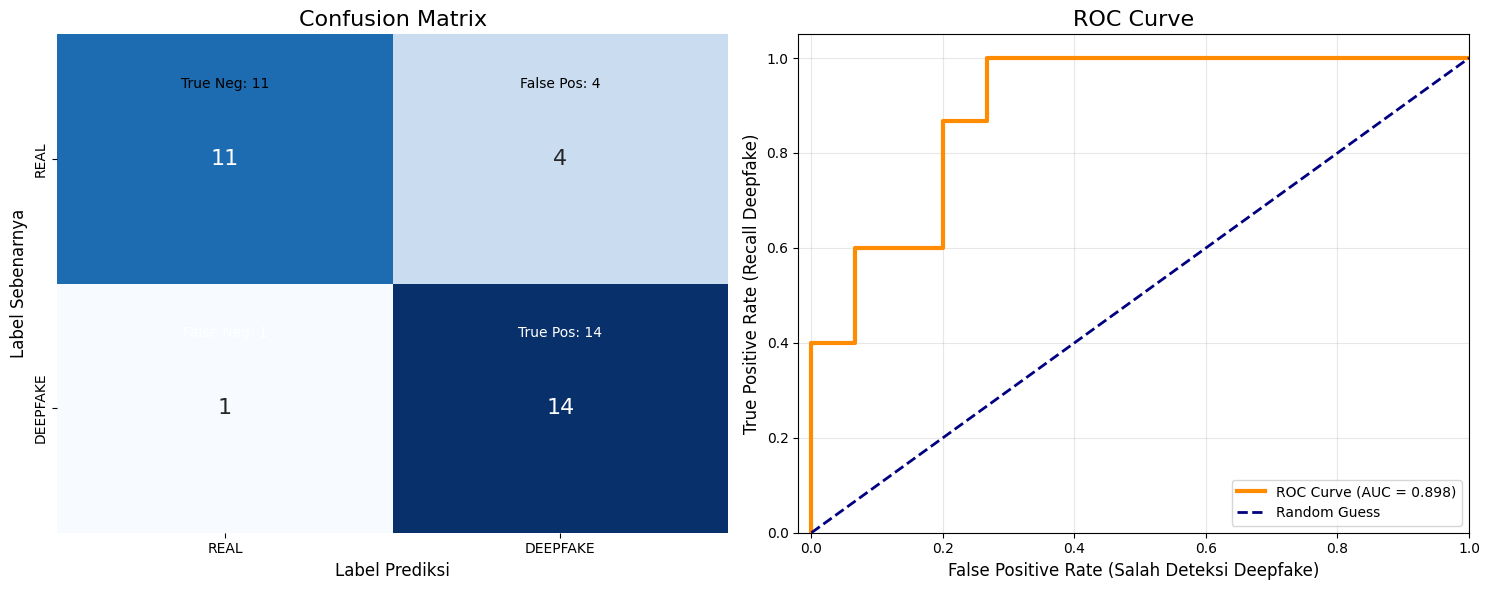


--- Classification Report ---
              precision    recall  f1-score   support

        REAL       0.92      0.73      0.81        15
    DEEPFAKE       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



: 

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

# --- KONFIGURASI ---
DATASET_PATH = r"C:\Users\KuePuki\Documents\MKA\CVL\UADFV" # Sesuaikan path asli
PROCESSED_PATH = "processed_data_kfold"
MODEL_FILENAME = "best_model_fold_1.keras" # Ganti dengan nama model fold terbaik Anda (misal fold_3 punya akurasi tertinggi)

# ==========================================
# BAGIAN 1: PERSIAPAN DATA (RE-LOAD)
# ==========================================
print("--- 1. Memuat Data Testing (30% Hold-out) ---")

# A. Muat Data Array (.npy)
try:
    X_test = np.load(os.path.join(PROCESSED_PATH, 'X_test.npy')).astype('float32')
    y_test = np.load(os.path.join(PROCESSED_PATH, 'y_test.npy'))
    print(f"Data Loaded: {len(X_test)} sampel uji.")
except FileNotFoundError:
    print("Error: File .npy tidak ditemukan. Jalankan preprocessing terlebih dahulu.")
    exit()

# B. (Opsional) Regenerasi 'test_paths' untuk mendapatkan nama file video
#    Kita ulangi logic split dengan random_state=42 agar urutannya PERSIS sama
print("--- Regenerasi Path Video untuk Labeling... ---")
all_video_paths = []
all_labels = []
categories = ['real', 'fake']

for category in categories:
    category_path = os.path.join(DATASET_PATH, category)
    if os.path.isdir(category_path):
        video_files = [f for f in os.listdir(category_path) if f.lower().endswith('.mp4')]
        for video_file in video_files:
            all_video_paths.append(os.path.join(category_path, video_file))
            all_labels.append(category)

# Split ulang dengan seed yang SAMA persis dengan preprocessing
_, test_paths, _, _ = train_test_split(
    all_video_paths, all_labels,
    test_size=0.3, 
    random_state=42, # KUNCI AGAR URUTAN SAMA
    stratify=all_labels
)

# Cek konsistensi
if len(test_paths) != len(X_test):
    print("Warning: Jumlah path video tidak sama dengan jumlah data X_test.")
    print("Mungkin ada video yang gagal diproses saat preprocessing awal.")
    # Kita akan menggunakan index angka saja jika jumlah tidak match
    use_filenames = False
else:
    print("Sinkronisasi Path Video Berhasil.")
    use_filenames = True

# ==========================================
# BAGIAN 2: MUAT MODEL & PREDIKSI
# ==========================================
print(f"\n--- 2. Memuat Model: {MODEL_FILENAME} ---")
try:
    # Load model (compile=False agar lebih aman jika ada custom metric/loss, kita hanya butuh predict)
    model = tf.keras.models.load_model(MODEL_FILENAME, compile=False) 
    print("Model berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    print("Pastikan nama file model sesuai dengan hasil training (misal: 'best_model_fold_1.keras')")
    exit()

print("\n--- 3. Melakukan Prediksi ---")
# Prediksi probabilitas (0.0 s/d 1.0)
predictions = model.predict(X_test, verbose=1)
# Konversi ke label biner (0 atau 1) dengan threshold 0.5
y_pred_labels = (predictions > 0.5).astype(int)

# ==========================================
# BAGIAN 3: LAPORAN DETIL PER VIDEO
# ==========================================
print("\n--- 4. Laporan Detil Prediksi ---")

# Limit output agar tidak terlalu panjang di console (tampilkan 10 pertama + yang salah prediksi)
print("(Menampilkan 10 sampel pertama dan semua kesalahan prediksi)\n")

correct_count = 0
for i in range(len(y_test)):
    true_label_int = y_test[i]
    pred_score = predictions[i][0]
    
    # Labeling
    predicted_str = "DEEPFAKE" if pred_score > 0.5 else "REAL"
    true_str = "DEEPFAKE" if true_label_int == 1 else "REAL"
    
    # Confidence (seberapa yakin model)
    confidence = pred_score if predicted_str == "DEEPFAKE" else 1 - pred_score
    
    # Status
    is_correct = (predicted_str == true_str)
    if is_correct: correct_count += 1
    status_icon = "✅" if is_correct else "❌ SALAH"
    
    # Nama File
    fname = os.path.basename(test_paths[i]) if use_filenames else f"Video Index {i}"

    # Tampilkan jika ini 10 pertama ATAU jika prediksi salah (untuk debugging)
    if i < 10 or not is_correct:
        print(f"[{i}] {fname}")
        print(f"   Prediksi: {predicted_str} ({confidence:.2%}) | Asli: {true_str} | {status_icon}")
        if not is_correct:
            print("   ⚠️ PERHATIKAN: Model gagal memprediksi video ini.")
        print("-" * 30)

print(f"\nTotal Akurasi Test Set: {correct_count}/{len(y_test)} ({(correct_count/len(y_test)):.2%})")

# ==========================================
# BAGIAN 4: VISUALISASI METRIK (CONFUSION MATRIX & ROC)
# ==========================================
print("\n--- 5. Visualisasi Evaluasi ---")

class_names = ['REAL', 'DEEPFAKE']

# A. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(15, 6))

# Subplot 1: Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)

# Tambahkan label tekstual di dalam kotak
# TP, TN, FP, FN logic
tn, fp, fn, tp = cm.ravel()
plt.text(0.5, 0.2, f"True Neg: {tn}", ha="center", va="center", color="black")
plt.text(1.5, 0.2, f"False Pos: {fp}", ha="center", va="center", color="black")
plt.text(0.5, 1.2, f"False Neg: {fn}", ha="center", va="center", color="white")
plt.text(1.5, 1.2, f"True Pos: {tp}", ha="center", va="center", color="white")

# B. ROC Curve
# Hitung FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Salah Deteksi Deepfake)', fontsize=12)
plt.ylabel('True Positive Rate (Recall Deepfake)', fontsize=12)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# C. Classification Report (Text Summary)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_labels, target_names=class_names))

In [12]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model # Asumsi pakai Keras/TensorFlow
from sklearn.preprocessing import LabelEncoder

# --- KONFIGURASI ---
MODEL_PATH = 'best_model_fold_1.keras'       # Ganti dengan path model Anda yang sudah dilatih
LABEL_ENCODER_PATH = r'C:\Users\KuePuki\Documents\MKA\CVL\processed_data\label_encoder.npy' # Path file label encoder
VIDEO_PATH_TO_TEST = r'C:\Users\KuePuki\Documents\MKA\CVL\PersonalMessage.mp4'      # Ganti dengan path video luar yang ingin dites

# Parameter harus SAMA PERSIS dengan saat training
SEQUENCE_LENGTH = 30
IMG_SIZE = 96

# Inisialisasi Detektor Wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def load_resources():
    print("Loading model and labels...")
    
    # 1. Load Model
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")
    model = load_model(MODEL_PATH)
    
    # 2. Load Label Encoder
    if not os.path.exists(LABEL_ENCODER_PATH):
        raise FileNotFoundError(f"Label encoder not found at {LABEL_ENCODER_PATH}")
    
    encoder_classes = np.load(LABEL_ENCODER_PATH)
    le = LabelEncoder()
    le.classes_ = encoder_classes
    
    return model, le

def preprocess_single_video(video_path):
    """
    Membaca 1 video, mengambil 30 frame wajah, dan mengubah ukurannya.
    Output shape: (1, 30, 96, 96, 3) -> Batch size 1
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Tidak bisa membuka video {video_path}")
        return None

    frames = []
    frame_count = 0
    
    while len(frames) < SEQUENCE_LENGTH:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Deteksi Wajah
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        if len(faces) > 0:
            # Ambil wajah terbesar
            (x, y, w, h) = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
            face = frame[y:y+h, x:x+w]
            
            # Resize ke ukuran yang dimengerti model (96x96)
            resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            
            # Normalisasi (PENTING: Sesuaikan dengan cara Anda melatih model)
            # Jika saat training data dibagi 255.0, di sini juga harus dibagi.
            # resized_face = resized_face / 255.0 
            
            frames.append(resized_face)
        
        frame_count += 1

    cap.release()

    # Cek apakah frame cukup
    if len(frames) == SEQUENCE_LENGTH:
        # Ubah list menjadi numpy array
        np_frames = np.array(frames)
        
        # Tambahkan dimensi Batch di depan -> (1, 30, 96, 96, 3)
        input_data = np.expand_dims(np_frames, axis=0)
        return input_data
    else:
        print(f"Gagal: Video terlalu pendek atau wajah tidak terdeteksi. (Dapat {len(frames)}/{SEQUENCE_LENGTH} frame)")
        return None

def predict_video():
    try:
        # 1. Persiapan
        model, le = load_resources()
        
        print(f"\nMemproses video: {VIDEO_PATH_TO_TEST}...")
        
        # 2. Preprocessing Video
        input_data = preprocess_single_video(VIDEO_PATH_TO_TEST)
        
        if input_data is None:
            return

        # 3. Prediksi
        print("Melakukan prediksi...")
        prediction = model.predict(input_data)
        
        # 4. Interpretasi Hasil
        # Asumsi output model adalah probabilitas (sigmoid) antara 0 dan 1
        # Jika model Anda softmax (2 neuron output), kodenya sedikit berbeda.
        
        confidence = prediction[0][0] # Ambil nilai probabilitas
        
        # Logika Threshold (Batas)
        if confidence > 0.5:
            predicted_index = 1
            prob_percent = confidence * 100
        else:
            predicted_index = 0
            prob_percent = (1 - confidence) * 100
            
        result_label = le.inverse_transform([predicted_index])[0]
        
        # 5. Tampilkan Output
        print("-" * 30)
        print(f"HASIL PREDIKSI: {result_label.upper()}")
        print(f"Confidence    : {prob_percent:.2f}%")
        print(f"Raw Score     : {confidence:.4f}")
        print("-" * 30)

    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

if __name__ == "__main__":
    predict_video()

Loading model and labels...

Memproses video: C:\Users\KuePuki\Documents\MKA\CVL\PersonalMessage.mp4...
Melakukan prediksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
------------------------------
HASIL PREDIKSI: FAKE
Confidence    : 72.77%
Raw Score     : 0.2723
------------------------------
